<a href="https://colab.research.google.com/github/mnguyen1901/text-generation/blob/main/Text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TEXT GENERATION**

**Models:**
1. *Word-based SeqtoVec - RNN*
    * For practice only; impracticle
2. *Word-based SeqtoSeq - RNN*
    * Good performance
    * Overfitting? Why accuracy is so high?
    * Is there a way to evaluate LSTM's state matrix? (this is how they store the context)
3. *Word-based SeqtoSeq - Transformer*
    * Long training time
    * **Terrible output** after 60 epochs, need more training
4. *GPT2*
    * They used 12 Decoder layers with 12 heads, 768 embedding dim, dff = 3072, window = 512. This is trained on a corpus of books (continuous text)
    * Paper link below.
5. *Character-based SeqtoVec - RNN*
    * OK performance
6. *Character-based SeqtoSeq - RNN*
    * Good performance but Word-based SeqtoSeq might be able to retain context better

**Data**:
* CPR.txt
    * Including syllabus, conferences and optional learning materials (can add pharm and path textbook and text in ppt)
    * 17611 sentences, 15048 words
    * 2468954 characters, 286 unique characters
    * 10% of the this dataset was manually editted to eliminate parsing error from pdfparser.
    * **NOTE:** There are still a lot of errors (parsing errors from reading equations/tables)
* NIH_Processed_Abstract.txt
    * 1.5 GB of NIH project abstracts from the last 10 years.
    * Some of the abstracts are not continuous text (bullet points). Don't know if this might affect contextualization (attention matrices)
    * **NOTE:** This will take a very long time to train. Each epoch can take 30-75+ minutes, depending on depth and  model. (RNN with 1 embedding, 3 LSTMs and 1 dense took 70 minutes)

**NOTE:**
* SeqtoSeq models are better then SeqtoVec with lower time/space complexity
* *HOW TO EVALUATE OVERFITTING AND PERFORMANCE?*

**USEFUL READING**:
* Similar to GPT3 **https://github.com/EleutherAI/gpt-neo/**
* https://www.tensorflow.org/tutorials/text/text_generation
* https://www.tensorflow.org/tutorials/text/transformer#create_the_transformer
* https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf
* https://www.tensorflow.org/tutorials/keras/save_and_load

**FUTURE:**
* Subword tokenization to reduce dimension, esp medical terminology
* Test Decoder or Encoder only. Not very useful to use E+D if the task is only text generation
* Implement GPT2 (might take a long time)
* Try this dataset, this is way cleaner. https://github.com/snigdhac/StoryComprehension_EMNLP/blob/master/Dataset/RoCStories/100KStories.csv

# **Setting up**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import time

In [ ]:
%cd /content/drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [ ]:
f = open("CPR copy.txt", "r")
text_data = f.read()
text_data

'After reading the Life Magazine article "They Decide Who Lives, Who Dies," what do you admire about the Seattle Artificial Kidney center\'s approach to selecting patients for dialysis? What criticisms of the process do you have? Dialysis allocation in 1960s Seattle Left untreated, end-stage renal disease is uniformly fatal, usually within weeks. With dialysis treatments to clear uremic toxins from the blood, regulate electrolytes, and remove excess fluid, people with end-stage renal disease can live for years. When hemodialysis was first made available in the 1960s, there were many more patients who could potentially benefit from dialysis treatment than could be accommodated by the limited number of machines. The Seattle Artificial Kidney Center was faced with making the "tragic choice" of which patients would live and which would die. The first decision made by the Kidney Center physicians was to limit candidates to those who they thought were likely to successfully tolerate the trea

In [ ]:
len(set(text_data))

114

In [ ]:
text_data[:100]

'After reading the Life Magazine article "They Decide Who Lives, Who Dies," what do you admire about '

# **WORD-BASED TEXT GENERATOR**

## Model 1 - Seq-to-Vec

**NOTE:**
- This approach is very impracticle. The generated y matrix will use a lot of RAM. That matrix takes about ~8GB for *HALF* of the CPR dataset and running the full dataset will crash colab

In [ ]:
dataset = text_data

In [ ]:
find = ['A. ', 'B. ', 'C. ', 'D. ', 'E. ', 'F. ', 'G. ', 'H. ', 'I. ', 'J. ', 'K. ', 'L. ', 'M. ', 'N. ', 'O. ',
        'P. ', 'Q. ', 'R. ', 'S. ', 'T. ', 'U. ', 'V. ', 'W. ', 'X. ', 'Y. ', 'Z. ', 'vs. ', 'Mr. ', 'Mrs. ',
        'Ms. ', 'i.e. ', 'e.g. ']

replace = ['A.', 'B.', 'C.', 'D.', 'E.', 'F.', 'G.', 'H.', 'I.', 'J.', 'K.', 'L.', 'M.', 'N.', 'O.',
           'P.', 'Q.', 'R.', 'S.', 'T.', 'U.', 'V.', 'W.', 'X.', 'Y.', 'Z.', 'vs', 'Mr ', 'Mrs ',
           'Ms ', 'ie ', 'eg ']

for i in range(len(find)):
    text_data = text_data.replace(find[i], replace[i])

text_data = text_data.replace('? ', '. ')

corpus = text_data.split('. ')

In [ ]:
count = 0
dataset = []
for i in corpus:
    if len(i) >= 10:
        dataset.append(i)

dataset = dataset[:round(len(dataset)*0.5)]
len(dataset)

9212

In [ ]:
dataset[0]

'After reading the Life Magazine article "They Decide Who Lives, Who Dies," what do you admire about the Seattle Artificial Kidney center\'s approach to selecting patients for dialysis'

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset)
total_words = len(tokenizer.word_index) + 1

print(total_words)

9901


In [ ]:
input_sequences = []
for line in dataset:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [ ]:
(input_sequences[10])

[184, 2237, 1, 683, 3767, 3768, 69, 3769, 252, 1864, 252, 5172]

In [ ]:
# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [ ]:
# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

In [ ]:
type(labels)

numpy.ndarray

In [ ]:
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
ys.size/(1024**3)

2.038535714149475

In [ ]:
embedding_dim = 64
rnn_units = 20

from tensorflow.keras import regularizers

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences = True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(total_words, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          694656    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 300)         258000    
_________________________________________________________________
dropout (Dropout)            (None, None, 300)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 5427)              548127    
_________________________________________________________________
dense_1 (Dense)              (None, 10854)             58915512  
Total params: 60,576,695
Trainable params: 60,576,695
Non-trainable params: 0
____________________________________________

In [ ]:
import os

# Directory where the checkpoints will be saved
checkpoint_dir = './word-based_CP'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    verbose=1)

In [ ]:
history = model.fit(xs, ys, epochs=2, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/2
6302/6302 [==============================] - 708s 107ms/step - loss: 7.0414 - accuracy: 0.0709

Epoch 00001: saving model to ./word-based_CP/ckpt_1
Epoch 2/2
6302/6302 [==============================] - 680s 108ms/step - loss: 6.3742 - accuracy: 0.1065

Epoch 00002: saving model to ./word-based_CP/ckpt_2


In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'./word-based_CP/ckpt_2'

In [ ]:
model.save('./saved_model/my_model.h5')

In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model.h5')

In [ ]:
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = new_model.fit(xs, ys, epochs=5, verbose=1)

Epoch 1/5
6302/6302 [==============================] - 678s 108ms/step - loss: 6.1753 - accuracy: 0.1331
Epoch 2/5
6302/6302 [==============================] - 677s 107ms/step - loss: 5.9137 - accuracy: 0.1449
Epoch 3/5
6302/6302 [==============================] - 678s 108ms/step - loss: 5.7566 - accuracy: 0.1538
Epoch 4/5
6302/6302 [==============================] - 676s 107ms/step - loss: 5.6342 - accuracy: 0.1621
Epoch 5/5
6302/6302 [==============================] - 683s 108ms/step - loss: 5.5276 - accuracy: 0.1692


In [ ]:
new_model.save('./saved_model/Word_based_TextGen.h5')

In [ ]:
for i in range(10):
  m = tf.keras.models.load_model('saved_model/Word_based_TextGen.h5')
  m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  h = m.fit(xs, ys, epochs=10, verbose=1)
  m.save('./saved_model/Word_based_TextGen.h5')

Epoch 1/10
6302/6302 [==============================] - 1504s 234ms/step - loss: 5.5191 - accuracy: 0.1772
Epoch 2/10
6302/6302 [==============================] - 1461s 232ms/step - loss: 5.5270 - accuracy: 0.1745
Epoch 3/10
6302/6302 [==============================] - 1453s 231ms/step - loss: 5.3978 - accuracy: 0.1835
Epoch 4/10
6302/6302 [==============================] - 1460s 232ms/step - loss: 5.2927 - accuracy: 0.1890
Epoch 5/10
6302/6302 [==============================] - 1461s 232ms/step - loss: 5.2044 - accuracy: 0.1953
Epoch 6/10
6302/6302 [==============================] - 1440s 228ms/step - loss: 5.1480 - accuracy: 0.1987
Epoch 7/10
6302/6302 [==============================] - 1427s 226ms/step - loss: 5.0768 - accuracy: 0.2050
Epoch 8/10
6302/6302 [==============================] - 1427s 226ms/step - loss: 5.0004 - accuracy: 0.2095
Epoch 9/10
6302/6302 [==============================] - 1424s 226ms/step - loss: 4.9431 - accuracy: 0.2143
Epoch 10/10
6302/6302 [==============

In [ ]:
ls

## Model 2- Seq-to-Seq

**Ideas:**
- Preprocess text to retain punctuations: ```.replace('. ', ' . ')```. Keep it simple for now.

In [ ]:
text = text_data
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
seq = tokenizer.texts_to_sequences([text])[0]
len(tokenizer.word_index)

2366963

In [ ]:
def seq_to_text(sequence):
    s = []
    for i in sequence:
        s.append(tokenizer.sequences_to_texts([[i]])[0])

    return ' '.join(s)

In [ ]:
print(seq_to_text(seq[:12]))
print(seq[:12])

after reading the life magazine article they decide who lives who dies


In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
window_size = 40

ids_dataset = tf.data.Dataset.from_tensor_slices(seq)
dataset = ids_dataset.batch(window_size + 1, drop_remainder=True)
dataset = dataset.map(split_input_target)
dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", seq_to_text(input_example.numpy()))
    print("Target:", seq_to_text(target_example.numpy()))

Input : after reading the life magazine article they decide who lives who dies what do you admire about the seattle artificial kidney center's approach to selecting patients for dialysis what criticisms of the process do you have dialysis allocation in 1960s
Target: reading the life magazine article they decide who lives who dies what do you admire about the seattle artificial kidney center's approach to selecting patients for dialysis what criticisms of the process do you have dialysis allocation in 1960s seattle


In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 512
rnn_units = 2048

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm1 = tf.keras.layers.LSTM(rnn_units, return_sequences=True, return_state=True)
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.lstm2 = tf.keras.layers.LSTM(rnn_units, return_sequences=True)
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.lstm3 = tf.keras.layers.LSTM(rnn_units, return_sequences=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.lstm1.get_initial_state(x)
        x, states_h, states_c = self.lstm1(x, initial_state=states, training=training)
        x = self.dropout(x)
        x = self.lstm2(x, training=training)
        x = self.dropout(x)
        x = self.lstm3(x, training=training)
        x = self.dense(x, training=training)


        if return_state:
            return x, [states_h, states_c]
        else:
            return x

In [ ]:
model = MyModel(vocab_size=vocab_size, embedding_dim=embedding_dim, rnn_units=rnn_units)

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [ ]:
epochs = 50
history = model.fit(dataset, epochs=epochs)

Epoch 1/50
142/142 [==============================] - 51s 193ms/step - loss: 7.5345 - accuracy: 0.0532
Epoch 2/50
142/142 [==============================] - 28s 194ms/step - loss: 7.0295 - accuracy: 0.0651
Epoch 3/50
142/142 [==============================] - 28s 194ms/step - loss: 7.0040 - accuracy: 0.0660
Epoch 4/50
142/142 [==============================] - 28s 194ms/step - loss: 6.9915 - accuracy: 0.0657
Epoch 5/50
142/142 [==============================] - 28s 193ms/step - loss: 6.9685 - accuracy: 0.0663
Epoch 6/50
142/142 [==============================] - 28s 194ms/step - loss: 6.7759 - accuracy: 0.0802
Epoch 7/50
142/142 [==============================] - 28s 194ms/step - loss: 6.4105 - accuracy: 0.0970
Epoch 8/50
142/142 [==============================] - 28s 194ms/step - loss: 6.1034 - accuracy: 0.1158
Epoch 9/50
142/142 [==============================] - 28s 194ms/step - loss: 5.8144 - accuracy: 0.1341
Epoch 10/50
142/142 [==============================] - 28s 194ms/step - l

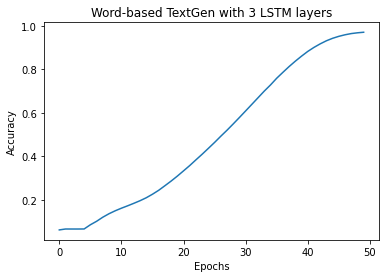

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('Word-based TextGen with 3 LSTM layers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
def generate_one_step(inputs, states=None):
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states =  model(inputs, states=states, return_state=True)

    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/temperature

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1).numpy()
    predicted_chars = [seq_to_text([[i]]) for i in predicted_ids]

    print(predicted_chars)

    return predicted_chars, states

In [ ]:
states = None
temperature = 0.2

seed = 'A 75 year-old female with history of'

seq = tokenizer.texts_to_sequences([seed])[0]
next_char = tf.constant([seq, seq, seq, seq, seq, seq, seq, seq, seq, seq,
                         seq, seq, seq, seq, seq, seq, seq, seq, seq, seq])

for i in range(30):
    predicted_logits, states =  model(next_char, states=None, return_state=True)
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/temperature
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.cast(predicted_ids, tf.int32)
    next_char = tf.concat([next_char, predicted_ids], 1)

for i in range(next_char.shape[0]):
    print(seq_to_text(next_char[i].numpy()))

a 75 year old female with history of a cough with progressive upper past 5 on physical exam they had a history of hepatitis c but denies having two medical past on exam the patient has a history
a 75 year old female with history of a cough for evaluation of episodic dyspnea and has not been seen for a routine well child check the upper child and cold upper heart and the upper left upper
a 75 year old female with history of a cough for several weeks they he has no edema and has no history of syncope the history of type 2 diabetes hypertension and hypertension he is on no medications
a 75 year old female with history of a history of diabetes and hypertension presents with palpitations and intermittent lightheadedness the patient reports no angina and has no history of syncope the 12 lead ecg is shown below
a 75 year old female with history of a cough for several weeks they he has no edema and has no history of syncope the history of a routine checkup exam is consistent with hypertension 

In [ ]:
print(states)

[<tf.Tensor: shape=(20, 2048), dtype=float32, numpy=
array([[ 2.3701640e-03,  8.2747525e-01, -8.5994229e-02, ...,
        -7.4500449e-06, -2.0773426e-07, -6.2827743e-03],
       [ 3.4359288e-03,  2.2039483e-03, -2.9033555e-02, ...,
        -7.7093184e-02, -2.5940808e-06, -8.2485425e-01],
       [ 6.5417155e-03,  7.5394619e-01, -1.7709194e-02, ...,
        -1.2370709e-05, -2.9860169e-07, -9.8018003e-01],
       ...,
       [ 3.7960437e-01,  6.8065703e-05, -5.7891575e-06, ...,
        -6.6705927e-02, -1.0288612e-07, -4.4503267e-06],
       [ 7.2826719e-01,  1.2146662e-02, -6.0371915e-04, ...,
        -6.0870148e-02, -2.0876962e-06, -2.6573383e-04],
       [ 6.4982887e-04,  7.6017267e-01, -8.9746244e-02, ...,
        -3.8464357e-05, -8.8199023e-08, -8.5454494e-01]], dtype=float32)>, <tf.Tensor: shape=(20, 2048), dtype=float32, numpy=
array([[ 3.4384254e+01,  2.7280535e+01, -2.6571852e+01, ...,
        -7.4500449e-06, -9.2355165e+00, -2.4840580e+01],
       [ 3.4154835e+01,  2.7055468e+01,

## Model 3 - Seq-to-Seq with Transformer

The problem can be rephrased as: what is probability of a word given a sequence (context)

Ref: https://www.tensorflow.org/tutorials/text/transformer#create_the_transformer

### Text processing

In [ ]:
text = text_data
tokenizer = Tokenizer(oov_token='[bos]')
tokenizer.fit_on_texts([text])
seq = tokenizer.texts_to_sequences([text])[0]
len(tokenizer.word_index)

13247

In [ ]:
def seq_to_text(sequence):
    s = []
    for i in sequence:
        s.append(tokenizer.sequences_to_texts([[i]])[0])

    return ' '.join(s)

In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    #input_text = tf.concat([tf.constant([1]), input_text], axis=0)
    target_text = sequence[-1:]
    target_text = tf.concat([tf.constant([1]), target_text], axis=0)
    return input_text, target_text

In [ ]:
vocab_size = len(tokenizer.word_index)
BATCH_SIZE = 64
BUFFER_SIZE = 10000
window_size = 50

ids_dataset = tf.data.Dataset.from_tensor_slices(seq)
dataset = ids_dataset.window(window_size + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
dataset = dataset.map(split_input_target)

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
dataset

<PrefetchDataset shapes: ((64, None), (64, None)), types: (tf.int32, tf.int32)>

In [ ]:
for (inp, out) in dataset.take(5):
    print(seq_to_text(inp[0].numpy()))
    print(seq_to_text(out[0].numpy()))
    print()

results how would you interpret these pulmonary function tests spirometry while the fev1 and fvc are reduced the fev1 is disproportionately reduced compared to the fvc resulting in the low fev1 fvc ratio because the fev1 fvc ratio is less than 0 70 the patient is deemed to have airflow
[bos] obstruction

risk genotype white patients with hiv and glomerular disease more commonly have an immune complex glomerulonephritis 5 what is the long term prognosis when hiv associated nephropathy hivan first became apparent in the 1980s patient outcomes were terrible the average patient was on dialysis within 3 months after diagnosis of
[bos] hivan

woman presents with a daily cough productive of white yellow sputum for the last several years she is a current smoker with a 35 pack year history of tobacco use in addition to the pulmonary function tests shown below she underwent a chest radiograph which was interpreted as normal how
[bos] would

area as well for all of these reasons allocation based 

### Positional encoding

To-read: https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb

In [ ]:
def get_angles(pos, i, d_model):
    # pos = (position, 1)
    # i = (1, d_model)
    # d_model = int
    # ==> angle_rates = (1, d_model)
    # ==> returns (position, d_model)
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
    # np.arange(position)[:, np.newaxis] will change matrix size from (position,) to (position, 1)
    # np.arange(d_model)[np.newaxis, :] will change matrix size from (d_model,) to (1, d_model)
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    # angle_rads.shape will be (pos, d_model)

    # apply sin/cos to even/odd indices. Why?
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    # Cast to convert to float32. It seems that np format is float64 while tensor if 32
    # Return (batch, seq, d_model)
    return tf.cast(pos_encoding, dtype=tf.float32)

### Masking

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [ ]:
x = tf.random.uniform((1, 5))
print(x)
temp = create_look_ahead_mask(x.shape[1])
temp

tf.Tensor([[0.82044137 0.9415277  0.544665   0.96381557 0.0163027 ]], shape=(1, 5), dtype=float32)


<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

### Attention matrix

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q: query shape = (..., seq_len_q, depth)
    k: key shape = (..., seq_len_k, depth)
    v: value shape = (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
        to (..., seq_len_q, seq_len_k). Defaults to None.
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add mask !?
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth)) # (batch_size, seq_len, num_heads, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])                       # (batch_size, num_heads, seq_len, depth)

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape = (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape = (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                    (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

### Defining the layers

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                        for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # Why multiply sqrt(512)?
        x += self.pos_encoding[:, :seq_len, :] # Positional encoding added

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training,
            look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                        for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
            look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape = (batch_size, target_seq_len, d_model)
        return x, attention_weights

### Custom model

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.tokenizer = Encoder(num_layers, d_model, num_heads, dff,
                            input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                            target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask,
            look_ahead_mask, dec_padding_mask):

        enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

**PARAM**
Try num_layers=6, d_model = 512, dff = 2048

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

### Loss function

This is the learning rate recommended by the paper

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

### Training

In [ ]:
# Positional encoding input and output are both set to 1000
transformer = Transformer(num_layers=num_layers,
                          d_model=d_model,
                          num_heads=num_heads,
                          dff=dff,
                          input_vocab_size=vocab_size+1,
                          target_vocab_size=vocab_size+1,
                          pe_input=1000,
                          pe_target=1000,
                          rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
EPOCHS = 20

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                    True,
                                    enc_padding_mask,
                                    combined_mask,
                                    dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    for (batch, (inp, tar)) in enumerate(dataset):
        inp = tf.cast(inp, dtype=tf.int64)
        tar = tf.cast(tar, dtype=tf.int64)
        train_step(inp, tar)

        if batch % 1000 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print (f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 7.6046 Accuracy 0.2812
Epoch 1 Batch 1000 Loss 5.1811 Accuracy 0.3622
Epoch 1 Batch 2000 Loss 5.1968 Accuracy 0.3662
Epoch 1 Batch 3000 Loss 5.1335 Accuracy 0.3739
Epoch 1 Batch 4000 Loss 5.2928 Accuracy 0.3636
Epoch 1 Batch 5000 Loss 5.3377 Accuracy 0.3583
Epoch 1 Loss 5.2776 Accuracy 0.3618
Time taken for 1 epoch: 370.26 secs

Epoch 2 Batch 0 Loss 6.0723 Accuracy 0.3125
Epoch 2 Batch 1000 Loss 5.1963 Accuracy 0.3611
Epoch 2 Batch 2000 Loss 5.2069 Accuracy 0.3663
Epoch 2 Batch 3000 Loss 5.1504 Accuracy 0.3742
Epoch 2 Batch 4000 Loss 5.2967 Accuracy 0.3638
Epoch 2 Batch 5000 Loss 5.3428 Accuracy 0.3585
Epoch 2 Loss 5.2826 Accuracy 0.3618
Time taken for 1 epoch: 366.45 secs

Epoch 3 Batch 0 Loss 5.7804 Accuracy 0.3438
Epoch 3 Batch 1000 Loss 5.1850 Accuracy 0.3627
Epoch 3 Batch 2000 Loss 5.1938 Accuracy 0.3666
Epoch 3 Batch 3000 Loss 5.1366 Accuracy 0.3740
Epoch 3 Batch 4000 Loss 5.2887 Accuracy 0.3639
Epoch 3 Batch 5000 Loss 5.3325 Accuracy 0.3590
Epoch 3 Loss 5.27

In [ ]:
vocab_size


13247

### Prediction

In [ ]:
temperature = 0.5

sentence = 'what would the renal biopsy be'

encoder_input = tokenizer.texts_to_sequences([sentence])[0]

encoder_input = tf.cast([encoder_input], dtype=tf.int64)
output = tf.cast([[1]], dtype=tf.int64)

for i in range(10):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

    print('INPUT:',encoder_input)
    print('OUTPUT:',output)
    predictions, attention_weights = transformer(encoder_input,
                                                    output,
                                                    False,
                                                    enc_padding_mask,
                                                    combined_mask,
                                                    dec_padding_mask)

    predictions = predictions[: ,-1:, :]

    # Greedy
    # predicted_id = tf.argmax(predictions, axis=-1)


    prob = tf.squeeze(predictions/temperature)
    prob = prob[np.newaxis,:]
    predicted_id = tf.random.categorical(prob, num_samples=1)
    print(tokenizer.sequences_to_texts(predicted_id.numpy()))
    encoder_input = tf.concat([encoder_input, predicted_id], axis=-1)

    print()

print(output)

INPUT: tf.Tensor([[ 42  83   2  77 745  17]], shape=(1, 6), dtype=int64)
OUTPUT: tf.Tensor([[1]], shape=(1, 1), dtype=int64)
['are']

INPUT: tf.Tensor([[ 42  83   2  77 745  17  11]], shape=(1, 7), dtype=int64)
OUTPUT: tf.Tensor([[1]], shape=(1, 1), dtype=int64)
['would']

INPUT: tf.Tensor([[ 42  83   2  77 745  17  11  83]], shape=(1, 8), dtype=int64)
OUTPUT: tf.Tensor([[1]], shape=(1, 1), dtype=int64)
['are']

INPUT: tf.Tensor([[ 42  83   2  77 745  17  11  83  11]], shape=(1, 9), dtype=int64)
OUTPUT: tf.Tensor([[1]], shape=(1, 1), dtype=int64)
['would']

INPUT: tf.Tensor([[ 42  83   2  77 745  17  11  83  11  83]], shape=(1, 10), dtype=int64)
OUTPUT: tf.Tensor([[1]], shape=(1, 1), dtype=int64)
['do']

INPUT: tf.Tensor([[ 42  83   2  77 745  17  11  83  11  83 143]], shape=(1, 11), dtype=int64)
OUTPUT: tf.Tensor([[1]], shape=(1, 1), dtype=int64)
['would']

INPUT: tf.Tensor([[ 42  83   2  77 745  17  11  83  11  83 143  83]], shape=(1, 12), dtype=int64)
OUTPUT: tf.Tensor([[1]], shape=

In [ ]:
set(output[0].numpy())

In [ ]:
set([ 847, 1166, 401, 5, 7921, 1241, 345, 974, 5939, 665])

In [ ]:
tokenizer.sequences_to_texts([[1]])

In [ ]:
for (batch, (inp, tar)) in enumerate(dataset):
    print(seq_to_text(inp[0].numpy()))
    print(seq_to_text(tar[0].numpy()))
    if batch == 0: break

scleritis deafness mononeuritis multiplex antibody mediated anti gbm disease goodpasture's syndrome anca associated svv gpa wegener's mpa microscopic polyangiitis lupus nephritis post infectious glomerulonephritis iga nephropathy henoch schonlein purpura mpgn cryoglobulinemic vasculitis hypersensitivity vasculitis drugs anca negative svv polyangiitis and egpa churg strauss syndrome what would the renal biopsy be
[bos] expected


## GPT2

https://huggingface.co/transformers/model_doc/gpt2.html#gpt2tokenizer

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.0MB 8.9MB/s 
     |████████████████████████████████| 3.2MB 43.5MB/s 
     |████████████████████████████████| 890kB 45.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=c1f9cd28756435c609f8baf75d28d7016443e2503840ba4727ace162f22f9619
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = TFGPT2LMHeadModel.from_pretrained("gpt2", output_attentions=True)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [ ]:
input_ids = tokenizer.encode('A 75 year-', return_tensors='tf')

sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=20,
    top_k=0,
    temperature=0.5
)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


In [ ]:
tokenizer.decode(sample_output[0])

'A 75 year-old man was arrested last week after allegedly using a mirror to look at a poster'

In [ ]:
sample_output

<tf.Tensor: shape=(1, 20), dtype=int32, numpy=
array([[   32,  5441,   614,    12,   727,   582,   373,  5169,   938,
         1285,   706,  7910,  1262,   257, 10162,   284,   804,   379,
          257, 11968]], dtype=int32)>

In [ ]:
attention_head = tf.squeeze(model(sample_output).attentions[11])
# shape: (num_heads, lenQ, lenK) - in the case of text generation/language modeling lenQ = lenK
#attention_head

In [ ]:
# Plot's label
l = tokenizer.convert_ids_to_tokens(sample_output[0])
l

['A',
 'Ġ75',
 'Ġyear',
 '-',
 'old',
 'Ġman',
 'Ġwas',
 'Ġarrested',
 'Ġlast',
 'Ġweek',
 'Ġafter',
 'Ġallegedly',
 'Ġusing',
 'Ġa',
 'Ġmirror',
 'Ġto',
 'Ġlook',
 'Ġat',
 'Ġa',
 'Ġposter']

### Attention Plot

These 2 functions are very similar. Use plot_attention_long for longer phrases and the other for shorter phrases.

In [ ]:
def plot_attention_long(attention_head):
    fig = plt.figure(figsize=(20,80))
    fig.text(0.5, 0.90, 'Keys', ha='center', fontsize='x-large', fontweight='semibold')
    fig.text(0.05, 0.5, 'Queries', va='center', rotation='vertical', fontsize='x-large', fontweight='semibold')

    for i in range(12):
        ax = plt.subplot(8,2,i+1)
        ax = sn.heatmap(attention_head[i].numpy(), cbar=False)
        ax.xaxis.tick_top()
        ax.set_xticklabels(l, rotation=90)
        ax.set_yticklabels(l, rotation=0)

    return fig

In [ ]:
def plot_attention_short(attention_head):
    fig = plt.figure(figsize=(20,16))
    fig.text(0.5, 0.95, 'Keys', ha='center', fontsize='x-large', fontweight='semibold')
    fig.text(0.05, 0.5, 'Queries', va='center', rotation='vertical', fontsize='x-large', fontweight='semibold')

    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        ax = sn.heatmap(attention_head[i].numpy(), cbar=False)
        ax.xaxis.tick_top()
        ax.set_xticklabels(l, rotation=90)
        ax.set_yticklabels(l, rotation=0)

    return fig

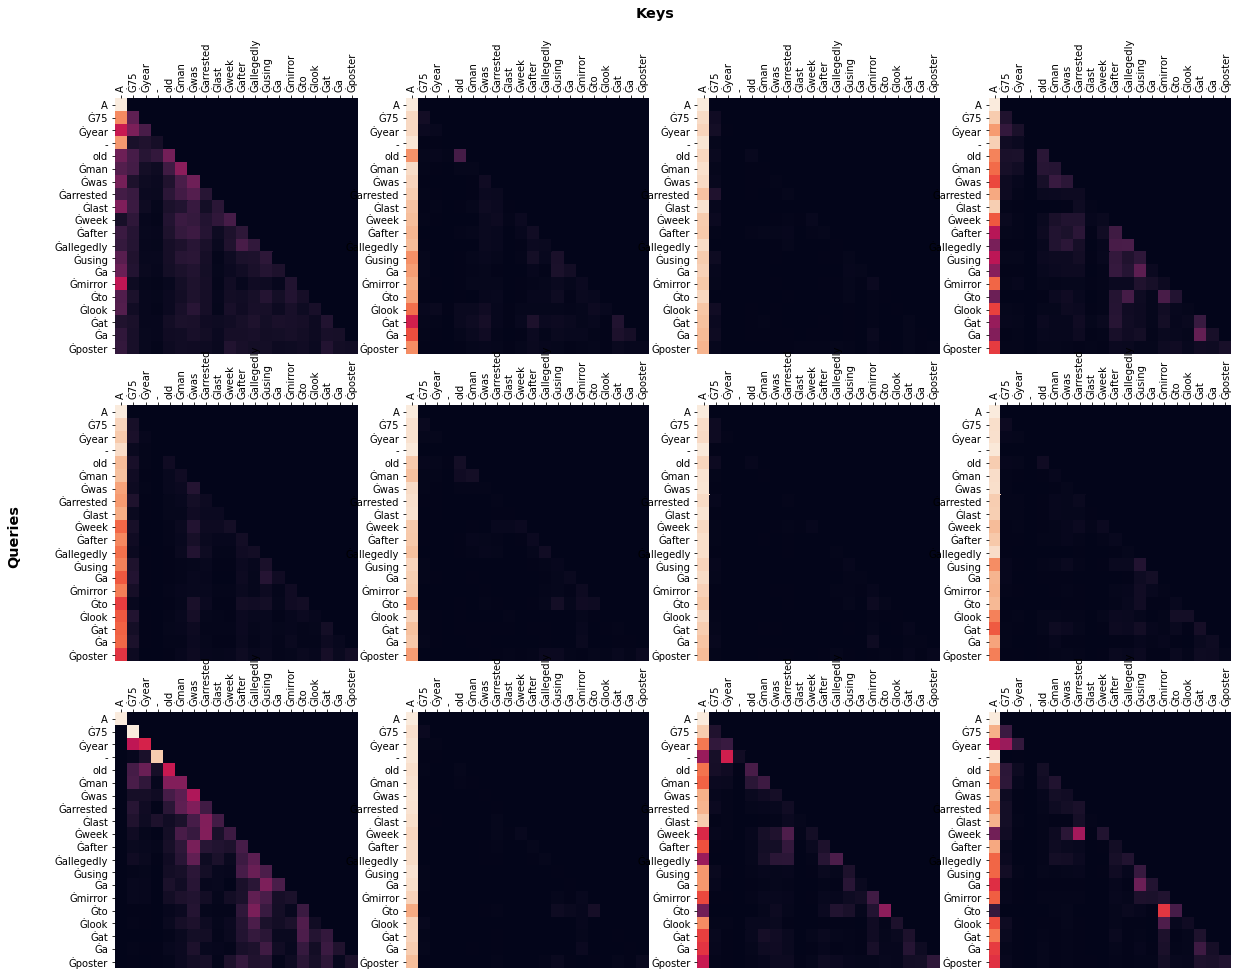

In [ ]:
fig = plot_attention_short(attention_head)

In [ ]:
# fig.savefig('Attention plots.jpg')

# **CHARACTER-BASED TEXT GENERATOR**

## Model 1 (Seq-to-Vec)

In [ ]:
print(len(text_data), 'chars in total')
vocab = sorted(set(text_data))
print(len(vocab), 'unique chars')

2411715 chars in total
135 unique chars


In [ ]:
char_to_indices = dict((c, i) for i, c in enumerate(vocab))
indices_to_char = dict((i, c) for i, c in enumerate(vocab))

In [ ]:
def tokenize(s):
  tok = []
  for i in s:
    tok.append(char_to_indices[i])
  return tok

In [ ]:
seq_length = 80
step = 5

x = []
next_char = []
for i in range(0, len(text_data)-seq_length, step):
  x.append(tokenize(text_data[i:i+seq_length]))
  next_char.append(char_to_indices[text_data[i+seq_length]])

print('size of x', len(x), '\n')
x = np.array(x)

size of x 482327 



In [ ]:
y = tf.keras.utils.to_categorical(next_char, num_classes=len(vocab))
y = np.array(y)

In [ ]:
vocab_size = len(vocab)

embedding_dim = 512
rnn1_units = 1024
rnn2_units = 512

In [ ]:
# Managing internal state by adding return_state=True

from tensorflow.keras import regularizers

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn1_units, return_sequences = True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(rnn2_units),
    tf.keras.layers.Dense(vocab_size/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 512)         69120     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 2048)        12591104  
_________________________________________________________________
dropout (Dropout)            (None, None, 2048)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               5244928   
_________________________________________________________________
dense (Dense)                (None, 67)                34371     
_________________________________________________________________
dense_1 (Dense)              (None, 135)               9180      
Total params: 17,948,703
Trainable params: 17,948,703
Non-trainable params: 0
____________________________________________

In [ ]:
epochs = 10
batch_size = 128

history = model.fit(x, y, batch_size=batch_size, epochs=epochs)

Epoch 1/10
3769/3769 [==============================] - 1267s 327ms/step - loss: 2.6375 - accuracy: 0.3170
Epoch 2/10
3769/3769 [==============================] - 1260s 334ms/step - loss: 1.7815 - accuracy: 0.5259
Epoch 3/10
3769/3769 [==============================] - 1266s 336ms/step - loss: 1.5340 - accuracy: 0.5836
Epoch 4/10
3769/3769 [==============================] - 1267s 336ms/step - loss: 1.4354 - accuracy: 0.6054
Epoch 5/10
3769/3769 [==============================] - 1268s 336ms/step - loss: 1.3663 - accuracy: 0.6221
Epoch 6/10
3769/3769 [==============================] - 1265s 336ms/step - loss: 1.3164 - accuracy: 0.6351
Epoch 7/10
3769/3769 [==============================] - 1272s 338ms/step - loss: 1.2724 - accuracy: 0.6456
Epoch 8/10
3769/3769 [==============================] - 1260s 334ms/step - loss: 1.2400 - accuracy: 0.6552
Epoch 9/10
3769/3769 [==============================] - 1273s 338ms/step - loss: 1.2112 - accuracy: 0.6626
Epoch 10/10
3769/3769 [==============

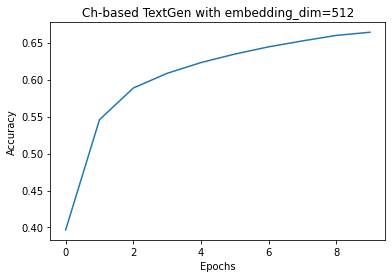

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('Ch-based TextGen with embedding_dim=' + str(embedding_dim))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
model.save('./saved_model/Char_based_TextGen_v3.h5')

### Prediction

In [ ]:
m_test = tf.keras.models.load_model('./saved_model/Char_based_TextGen_v2.h5')

In [ ]:
seed = 'Chronic cocaine abuse increases risk for dilated'
len(seed)

48

In [ ]:
if len(seed) < seq_length:
  pad = ' '*(seq_length - len(seed))
  seed_mod = pad + seed
elif len(seed) > seq_length:
  seed_mod = seed[-seq_length:]
print(seed_mod)

 Chronic cocaine abuse increases risk for dilated


In [ ]:
def generator_wo_sampling(seed_mod):
  s = seed_mod
  ans = ''
  for i in range(40):
    x_test = tokenize(s)
    y_pred = m_test.predict([x_test])[0]
    next = indices_to_char[np.argmax(y_pred)]
    ans += next
    s = s[1:] + next

  return ans

In [ ]:
def generator_with_sampling(seed_mod):
    def sample(pred, temperature=1.0):
        # helper function to sample an index from a probability array
        pred = np.asarray(pred).astype("float64")
        pred = np.log(pred) / temperature
        exp_preds = np.exp(pred)
        pred = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, pred, 1)
        return np.argmax(probas)

    s = seed_mod
    ans = ''

    for i in range(40):
        x_test = tokenize(s)
        y_pred = m_test.predict([x_test])[0]
        next_index = sample(y_pred)
        next = indices_to_char[next_index]
        ans += next
        s = s[1:] + next

    return ans

In [ ]:
print(seed + generator_wo_sampling(seed_mod))

for trial in range(3):
  print(seed + generator_with_sampling(seed_mod))

Chronic cocaine abuse increases risk for dilated and a simplified metabolic acidosis (Fi


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


Chronic cocaine abuse increases risk for dilated water in an infection. He also given. T
Chronic cocaine abuse increases risk for dilated cases from expiratory responsif saturat
Chronic cocaine abuse increases risk for dilated oxygen (changes. These patients, if his


## Model 2 (Seq-to-Seq)
Ref - https://www.tensorflow.org/tutorials/text/text_generation#build_the_model

**Ideas:**
- Stack RNN. Better than single RNN.
- Instead of batch spliting, iterate with step=10 to get sequence. Somehow a lot of overfitting with large data!?
- TRANSFORMER!!

In [ ]:
text = text_data
print(len(text))
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

2367108
114 unique characters


In [ ]:
# Define functions
ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab))
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True)

def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

window_size = 100

def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

dataset = ids_dataset.batch(window_size + 1, drop_remainder=True)
dataset = dataset.map(split_input_target)

In [ ]:
all_ids[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([36, 71, 85, 70, 83,  4, 83, 70, 66, 69])>

In [ ]:
for input_example, target_example in dataset.take(5):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'After reading the Life Magazine article "They Decide Who Lives, Who Dies," what do you admire about '
Target: b'fter reading the Life Magazine article "They Decide Who Lives, Who Dies," what do you admire about t'
Input : b"he Seattle Artificial Kidney center's approach to selecting patients for dialysis? What criticisms o"
Target: b"e Seattle Artificial Kidney center's approach to selecting patients for dialysis? What criticisms of"
Input : b' the process do you have? Dialysis allocation in 1960s Seattle Left untreated, end-stage renal disea'
Target: b'the process do you have? Dialysis allocation in 1960s Seattle Left untreated, end-stage renal diseas'
Input : b'e is uniformly fatal, usually within weeks. With dialysis treatments to clear uremic toxins from the'
Target: b' is uniformly fatal, usually within weeks. With dialysis treatments to clear uremic toxins from the '
Input : b'blood, regulate electrolytes, and remove excess fluid, people with end-stage renal disease can

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(ids_from_chars.get_vocabulary())
embedding_dim = 512
rnn_units = 2048

Run this to understand more about LSTM return_state, which returns output, a hidden state (similar to output) and cell state (storing context)

```
a = tf.keras.layers.Input(shape=(3,1))
print(a)
lstm1, state_h, state_c = LSTM(1, return_state=True)(a)
model = tf.keras.models.Model(inputs=a, outputs=[lstm1, state_h, state_c])
data = np.array([0.1, 0.2, 0.3]).reshape((1,3,1))
print(model.predict(data))
```

Bidirectional(LSTM(...) will return lstm, forward_h, forward_c, backward_h, backward_c

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm1 = tf.keras.layers.LSTM(rnn_units, return_sequences=True, return_state=True)
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.lstm2 = tf.keras.layers.LSTM(rnn_units, return_sequences=True)
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.lstm3 = tf.keras.layers.LSTM(rnn_units, return_sequences=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.lstm1.get_initial_state(x)
        x, states_h, states_c = self.lstm1(x, initial_state=states, training=training)
        x = self.dropout(x)
        x = self.lstm2(x, training=training)
        x = self.dropout(x)
        x = self.lstm3(x, training=training)
        x = self.dense(x, training=training)


        if return_state:
            return x, [states_h, states_c]
        else:
            return x

In [ ]:
model = MyModel(vocab_size=vocab_size, embedding_dim=embedding_dim, rnn_units=rnn_units)

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [ ]:
# checkpoint_dir = './2LSTM_1024rnn_1024em_NIH'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_prefix,
#     save_weights_only=True)

In [ ]:
epochs = 50
history = model.fit(dataset, epochs=epochs)

Epoch 1/50
366/366 [==============================] - 140s 316ms/step - loss: 3.3490 - accuracy: 0.1741
Epoch 2/50
366/366 [==============================] - 117s 317ms/step - loss: 1.9513 - accuracy: 0.4430
Epoch 3/50
366/366 [==============================] - 117s 317ms/step - loss: 1.4042 - accuracy: 0.5933
Epoch 4/50
366/366 [==============================] - 117s 317ms/step - loss: 1.2451 - accuracy: 0.6344
Epoch 5/50
366/366 [==============================] - 117s 318ms/step - loss: 1.1598 - accuracy: 0.6565
Epoch 6/50
366/366 [==============================] - 117s 318ms/step - loss: 1.1036 - accuracy: 0.6710
Epoch 7/50
366/366 [==============================] - 117s 317ms/step - loss: 1.0540 - accuracy: 0.6845
Epoch 8/50
366/366 [==============================] - 117s 318ms/step - loss: 1.0150 - accuracy: 0.6949
Epoch 9/50
366/366 [==============================] - 117s 318ms/step - loss: 0.9786 - accuracy: 0.7049
Epoch 10/50
366/366 [==============================] - 117s 318m

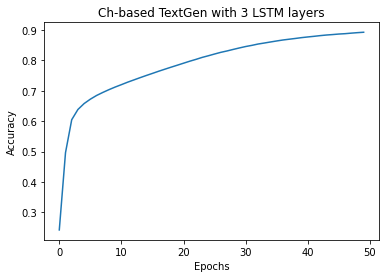

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('Ch-based TextGen with 3 LSTM layers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
class OneStep(tf.keras.Model):
    def __init__(self, model, chars_from_ids, ids_from_chars, temperature=0.5):
        super().__init__()
        self.temperature=temperature
        self.model = model
        self.chars_from_ids = chars_from_ids
        self.ids_from_chars = ids_from_chars

        # Create a mask to prevent "" or "[UNK]" from being generated.
        skip_ids = self.ids_from_chars(['','[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(
            values=[-float('inf')]*len(skip_ids),
            indices = skip_ids,
            dense_shape=[len(ids_from_chars.get_vocabulary())])
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    @tf.function
    def generate_one_step(self, inputs, states=None):
        input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
        input_ids = self.ids_from_chars(input_chars).to_tensor()

        # predicted_logits.shape is [batch, char, next_char_logits]
        predicted_logits, states =  self.model(inputs=input_ids, states=states,
                                            return_state=True)
        # Only use the last prediction.
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits/self.temperature
        # Apply the prediction mask: prevent "" or "[UNK]" from being generated.
        predicted_logits = predicted_logits + self.prediction_mask

        # tf.print(predicted_logits)

        # Sample the output logits to generate token IDs.
        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)

        # tf.print(predicted_ids)

        # Convert from token ids to characters
        predicted_chars = self.chars_from_ids(predicted_ids)

        # Return the characters and model state.
        return predicted_chars, states


one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

### Prediction

In [ ]:
states = None

seed = 'A 75 year-old female with history of'

next_char = tf.constant([seed, seed, seed, seed, seed, seed, seed, seed, seed, seed,
                         seed, seed, seed, seed, seed, seed, seed, seed, seed, seed])

for i in range(200):
    pred, states = one_step_model.generate_one_step(next_char, states=states)
    next_char = tf.strings.join([next_char, pred])

print(next_char)

tf.Tensor(
[b'A 75 year-old female with history of duration of action in the ED decides he should be identified as kidney transplantation (parasympathetic activity) which mediates vasoconstriction in vascular smooth muscle cells. Recall that the EFF '
 b'A 75 year-old female with history of duration of action in the ED with a holes in the nephron by surrounding stone formation. BENI Aldosterone bilaterally (DAAS inhibitors) are reserved for patients with high dose steroids (e.g., uric a'
 b'A 75 year-old female with history of duration of action in the ECG changes resolve. Initial problems: ESRD secondary to conduction abnormalities resulting in hemodynamic stress. Shortness of breath on heart rate on contractility represe'
 b'A 75 year-old female with history of heart disease. Failure to treat this patient has a clinical syndrome suggestive of low cardiac output and decreased systemic vascular resistance, but potentially fatal increase in vascular smooth mus'
 b'A 75 year-old female w

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')

INFO:tensorflow:Assets written to: one_step/assets


INFO:tensorflow:Assets written to: one_step/assets
